# 根据fake_tweets产生的数据文件进行分析

In [2]:
from my_weapon import *
from collections import defaultdict, Counter
from IPython.display import display

In [8]:
%time groups_url_tweets = [json.load(open("disk/url_ts_media_{}.json".format(i))) for i in range(8)]

CPU times: user 1min 2s, sys: 11.6 s, total: 1min 13s
Wall time: 1min 13s


In [ ]:
map_labels = {
    "0": "fake",
    "1": "extreme bias (right)",
    "2": "right",
    "3": "right leaning",
    "4": "center",
    "5": "left leaning",
    "6": "left",
    "7": "extreme bias (left)"
}

def get_cdf_pdf(data, mini, maxi, step, norm=True):
    x = np.arange(mini, maxi, step)
    cdf = np.zeros(len(x))
    pdf = np.zeros(len(x))
    for d in data:
        d = float(d)
        if d < mini or d >= maxi:
            continue
            
        for i, _x in enumerate(x):
            if d >= _x:
                cdf[i] += 1
                
            if i == (len(x) - 1):
                pdf[i] += 1
            elif _x <= d < x[i+1]: 
                pdf[i] += 1

    if norm:
        cdf = cdf / sum(pdf)
        pdf = pdf / sum(pdf)

    return x, cdf, pdf

plt.figure(figsize=(10, 6))
for i in range(8):
    print(i, "...")
    url_tweets = groups_url_tweets[i]
    data = pd.Series([len(url_tweet["tweets"]) for url_tweet in url_tweets])
    x, cdf, pdf = get_cdf_pdf(data, 0, 50000, 500)
    l0 = plt.plot(x, cdf, label=map_labels[str(i)])
#     data.hist(bins=50)
    
plt.title('Distribution of number of tweets in each news', fontsize=15)
plt.ylabel('N of news', fontsize=14)
plt.xlabel('N of tweets referring to this news', fontsize=14)
plt.xticks(fontsize=13); plt.yticks(fontsize=13)
plt.legend()
plt.yscale("log")
plt.xscale("log")
#     plt.savefig('fig/distribution_size_fake_news.pdf', dpi=300)

plt.show()
plt.close()

0 ...
1 ...
2 ...


- 189620条谣言URL, 914272条初始推特；
- 25212个第一条谣言的用户, 88215个发初始推特的用户；

### 专门针对用户的分析，放到analyze_users.ipy中～

In [5]:
import pendulum
   
def plot_day(i, url, sorted_dts, sorted_dts2=None, save=False):
    """
    包含了两条线！
    """

    plt.figure(figsize=(10, 6))
    ts = cal_ts_day(sorted_dts)
    ts.plot()
    
    if sorted_dts2:
        ts2 = cal_ts_day(sorted_dts2)
        ts2.plot()
    
    # configure
    plt.ylabel('N of tweets with this fake news', fontsize=15)
    plt.xticks(fontsize=11); plt.yticks(fontsize=11)
#     plt.xlabel('$Date$', fontsize=15)
#     plt.title(url)
    
    if save:
        plt.savefig('fig/{}-{}-overall-spread.pdf'.format(i, url), dpi=300)
    else:
        plt.show()
    
    plt.close()


def plot_48hours(i, url, sorted_dts, sorted_dts2=None, save=False):
    """
    包含了两条线！
    """
    
#     print(url)
#     print("实际传播开始和结束时间：", sorted_dts[0], sorted_dts[-1])

    plt.figure(figsize=(10, 6))
    ts = cal_ts_48hours(sorted_dts)
    ts.plot()
    
    if sorted_dts2:
        ts2 = cal_ts_48hours(sorted_dts2)
        ts2.plot()

    
    # configure
    plt.ylabel('N of tweets with this fake news', fontsize=15)
    plt.xticks(fontsize=11); plt.yticks(fontsize=11)
#     plt.xlabel('$Date$', fontsize=15)
#     plt.title(url)

    if save:
        plt.savefig('fig/{}-{}-first-48-hours.pdf'.format(i, url), dpi=300)
    else:
        plt.show()
        
    plt.close()


plot 1 ~


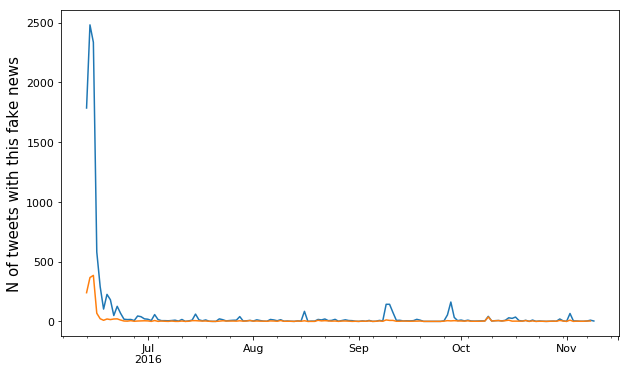

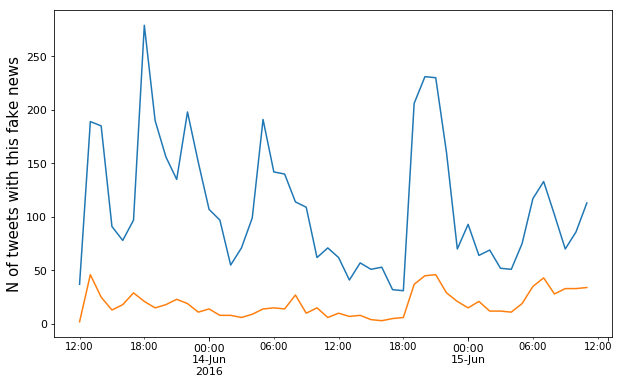

plot 2 ~


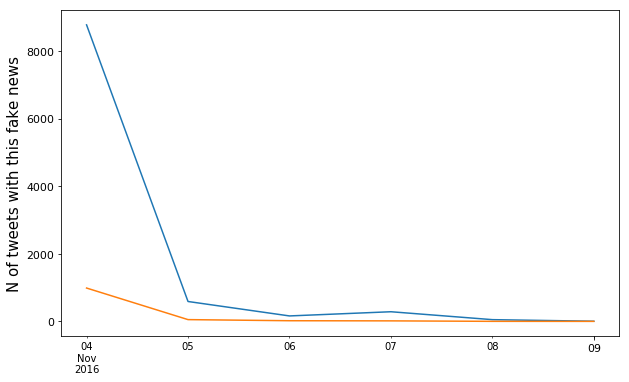

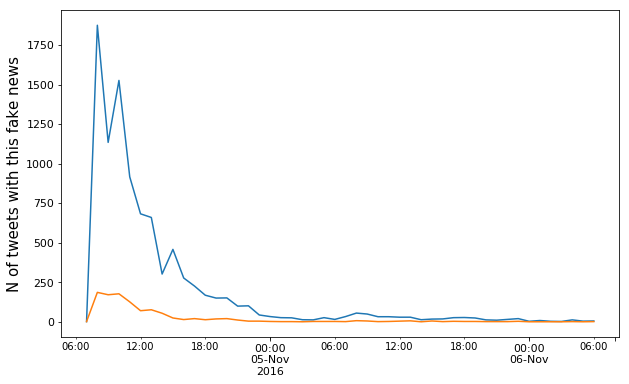

In [6]:
for i, url_tweet in enumerate(url_tweets):

    if i == 0:
        continue
    if i >= 3:
        break
    print("plot {} ~".format(i))
    
    url = url_tweet["url"]
    tweets_list = url_tweet["tweets"]
    dts = [t["dt"] for t in tweets_list]
    
    dts2 = [t["dt"] for t in tweets_list if t["is_source"]==1]
    plot_day(i, url, dts, dts2)
    plot_48hours(i, url, dts, dts2)

#     plot_day(i, url, dts)
#     plot_48hours(i, url, dts)

---

## source对trump和hillary的态度

In [3]:
from SQLite_handler import opinion

first_opinion = []
staters_opinion = []
other_opinion = []

tweets_csv = pd.read_csv("data/fake-tweets.csv", usecols=["tweet_id", "is_first", "is_source"])


for i, row in tqdm(tweets_csv.iterrows()):
    tid = row["tweet_id"]
    opi = opinion(tid)
    if row["is_first"] == 1:
        first_opinion.append(opi)
    if row["is_source"] == 1:
        staters_opinion.append(opi)
    else:
        other_opinion.append(opi)
    

2562218it [10:21, 4120.16it/s]


Counter({1: 145411, 0: 43464, -1: 587})
Counter({1: 713400, 0: 181059, -1: 2585})
Counter({1: 1488826, 0: 175888, -1: 460})


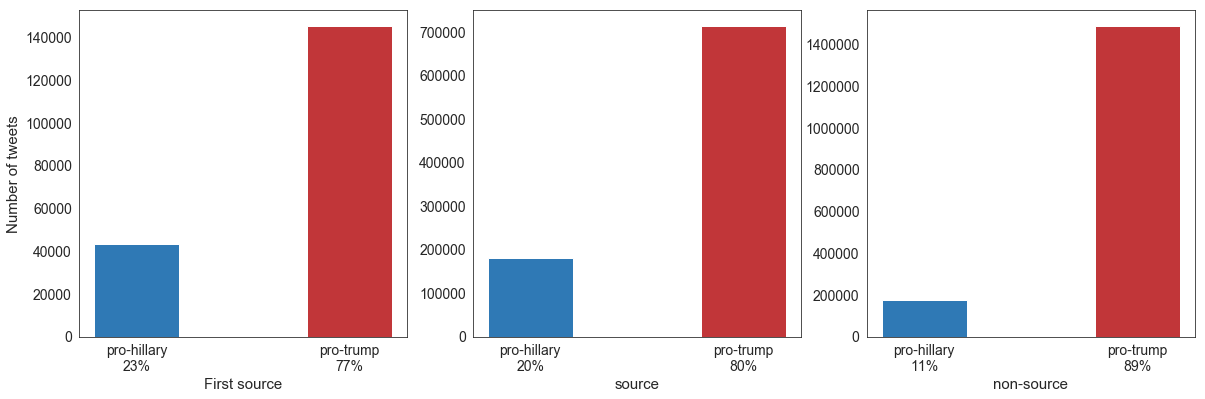

In [29]:
from collections import Counter
sns.set_style("white")
sns.color_palette("RdBu", n_colors=7)

count = Counter(first_opinion)
print(count)

label = ["pro-hillary", "pro-trump"]
plt.figure(figsize=(20, 6))

plt.subplot(131)
plt.bar(1, count[0], color=sns.color_palette("RdBu")[5], width=0.2)
plt.bar(1.5, count[1], color=sns.color_palette("RdBu")[0], width=0.2)
label = ["pro-hillary\n{0:.0%}".format(count[0] / (count[0]+count[1])), "pro-trump\n{0:.0%}".format(count[1] / (count[0]+count[1]))]
plt.xticks([1, 1.5], label)
plt.xlabel('First source', fontsize=15)
plt.ylabel('Number of tweets', fontsize=15)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)

count = Counter(staters_opinion)
print(count)

plt.subplot(132)
plt.bar(1, count[0], color=sns.color_palette("RdBu")[5], width=0.2)
plt.bar(1.5, count[1], color=sns.color_palette("RdBu")[0], width=0.2)
label = ["pro-hillary\n{0:.0%}".format(count[0] / (count[0]+count[1])), "pro-trump\n{0:.0%}".format(count[1] / (count[0]+count[1]))]
plt.xticks([1, 1.5], label)
plt.xlabel('source', fontsize=15)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)

count = Counter(other_opinion)
print(count)

plt.subplot(133)
plt.bar(1, count[0], color=sns.color_palette("RdBu")[5], width=0.2)
plt.bar(1.5, count[1], color=sns.color_palette("RdBu")[0], width=0.2)
label = ["pro-hillary\n{0:.0%}".format(count[0] / (count[0]+count[1])), "pro-trump\n{0:.0%}".format(count[1] / (count[0]+count[1]))]
plt.xticks([1, 1.5], label)
plt.xlabel('non-source', fontsize=15)
# plt.ylabel('N of fake sources', fontsize=15)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)

plt.savefig("fig/support.pdf", dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [9]:
uids_of_IRA = set(json.load(open("data/IRA_map.json")).values())

## 下面对fake-tweets.csv分析

In [62]:
len(tweets_csv["tweet_id"].unique())

2492013

## tweets_csv有多少url，多少is_source，多少is_first

In [8]:
len(tweets_csv["URL"].unique()), len(tweets_csv["user_id"].unique())

(184297, 208367)

## * 基于用户的转发网络构建

In [26]:
retweet_network = json.load(open("data/fake_retweet_network.json"))

In [20]:
def save_network():
    G = nx.DiGraph()

    nodes = tweets_csv["user_id"].tolist()
    edges = []
    dict_tweetid_userid = {}
    for _, row in tweets_csv.iterrows():
        dict_tweetid_userid[row["tweet_id"]] = row["user_id"]
    
    for n2, n1 in retweet_network.items():
        u1 = dict_tweetid_userid[n1]
        u2 = dict_tweetid_userid[n2]
        edges.append((u1, u2))

    print("add nodes from ...")
    G.add_nodes_from(nodes)
    print("add edge from ...")
    G.add_edges_from(edges)
    nx.write_gpickle(G, "data/fake_network.gpickle")
    
save_network()


188949it [00:26, 22041.75it/s]

add nodes from ...
add edge from ...


In [22]:
G = nx.read_gpickle("data/fake_network.gpickle")

In [25]:
G.number_of_nodes()

208367

In [26]:
G.number_of_edges()

1031782

In [29]:
import graph_tool.all as gt

def save_network_gt():
    g = gt.Graph()

    nodes = tweets_csv["user_id"].tolist()
    node_map = {n:i for i, n in enumerate(nodes)}
    
    dict_tweetid_userid = {}
    for _, row in tweets_csv.iterrows():
        dict_tweetid_userid[row["tweet_id"]] = row["user_id"]
    
    print("add nodes from ...")
    vlist = g.add_vertex(len(nodes))
        
    edges = []
    print("add edge from ...")
    for n2, n1 in retweet_network.items():
        u1 = node_map[dict_tweetid_userid[n1]]
        u2 = node_map[dict_tweetid_userid[n2]]
        g.add_edge(g.vertex(u1), g.vertex(u2))

    g.save("data/fake_network.gt")
    
save_network_gt()

add nodes from ...
add edge from ...


In [262]:
g = gt.load_graph("data/fake_network.gt")

In [273]:
g.vp.CI_out[3]

0

In [65]:
from random import random

def deg_sample():
    if random() > 0.5:
        return np.random.poisson(4), np.random.poisson(4)
    else:
        return np.random.poisson(20), np.random.poisson(20)
    
g = gt.random_graph(100, deg_sample)
g.save("data/test_network.gt")

In [73]:
# test graph-tool

# import graph_tool.draw

g = gt.Graph()
g.add_vertex(3)
g.add_edge(g.vertex(0), g.vertex(1))
for v in g.vertices():
    print(v)
for e in g.edges():
    print(e)

0
1
2
(0, 1)


## Their CI rank

data/fake_winners.json

In [118]:
winners = json.load(open("data/fake_winners.json"))

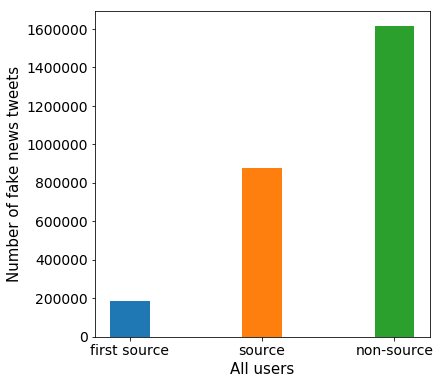

In [82]:
label = ["first source", "source", "non-source"]
plt.figure(figsize=(6, 6))

# plt.subplot(131)

plt.bar(1, len(tweets_csv[tweets_csv["is_first"]==1]), width=0.3)
plt.bar(2, len(tweets_csv[tweets_csv["is_source"]==1]), width=0.3)
plt.bar(3, len(tweets_csv[tweets_csv["is_source"]==0]), width=0.3)

plt.xticks([1, 2, 3], label)
plt.xlabel('All users', fontsize=15)
plt.ylabel('Number of fake news tweets', fontsize=15)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.savefig("fig/N-of-all-users.pdf", dpi=300, bbox_inches='tight')
plt.show()
plt.tight_layout()
plt.close()

In [3]:
source_tweets = tweets_csv[tweets_csv["is_source"]==1]
"曾经为source的用户量", len(source_tweets["user_id"].unique())

('曾经为source的用户量', 84370)

### 分析fake news的source_content

In [14]:
import SQLite_handler
import importlib
importlib.reload(SQLite_handler)
    
tweet_ids = source_tweets["tweet_id"].tolist()
rsts = SQLite_handler.find_source(tweet_ids)

In [19]:
count = [r["source_content"] for r in rsts if r["source_content"] != -1]
_sum = len(count)
print("amount of tweets of which source can be found:", _sum)
count = Counter(count)

for k, v in count.most_common(20):
    print(k, '- {:.2%}'.format(v / _sum))

amount of tweets of which source can be found: 876655
Twitter Web Client - 33.36%
dlvr.it - 22.55%
Twitter for iPhone - 7.94%
Facebook - 7.71%
Twitter for Android - 5.80%
Twitter for iPad - 3.15%
Put your button on any page!  - 2.81%
Mobile Web - 2.48%
twitterfeed - 2.23%
IFTTT - 1.62%
Hootsuite - 1.04%
SocialOomph - 0.88%
Sprout Social - 0.86%
Linkis.com - 0.84%
Buffer - 0.64%
WordPress.com - 0.47%
Rignite - 0.41%
OS X - 0.32%
TweetDeck - 0.32%
Mobile Web (M5) - 0.26%


In [86]:
first_tweets = tweets_csv[tweets_csv["is_first"]==1]
"曾经为first source的用户量", len(first_tweets["user_id"].unique())

('曾经为first source的用户量', 24446)

In [31]:
ira_tweets = tweets_csv[tweets_csv["is_IRA"]==1]
'IRA用户量', len(ira_tweets["user_id"].unique())

('IRA用户量', 92)

说明并没有匿名用户存在，非常好

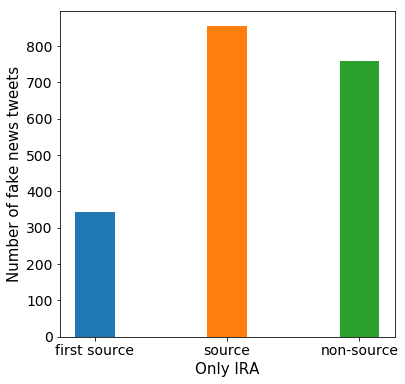

In [93]:
label = ["first source", "source", "non-source"]
plt.figure(figsize=(6, 6))

# plt.subplot(131)
plt.bar(1, len(ira_tweets[ira_tweets["is_first"]==1]), width=0.3)
plt.bar(2, len(ira_tweets[ira_tweets["is_source"]==1]), width=0.3)
plt.bar(3, len(ira_tweets[ira_tweets["is_source"]==0]), width=0.3)

# label = ["pro-hillary\n{0:.0%}".format(count[0] / (count[0]+count[1])), "pro-trump\n{0:.0%}".format(count[1] / (count[0]+count[1]))]
plt.xticks([1, 2, 3], label)
plt.xlabel('Only IRA', fontsize=15)
plt.ylabel('Number of fake news tweets', fontsize=15)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.savefig("fig/N-of-only-IRA.pdf", dpi=300, bbox_inches='tight')
plt.show()
plt.tight_layout()
plt.close()

## The influence of IRAs in fake news spreading

### IRA涉及了哪些URL

In [94]:
ira_url = set(ira_tweets["URL"])
ira_first_url = set(ira_tweets[ira_tweets["is_first"]==1]["URL"])
ira_source_url = set(ira_tweets[ira_tweets["is_source"]==1]["URL"])
non_source_url = set(ira_tweets[ira_tweets["is_source"]==0]["URL"])

len(ira_url), len(ira_first_url), len(ira_source_url), len(non_source_url)

(1274, 344, 696, 600)

### IRA涉及的URL影响了多少其他人？

In [95]:
from tqdm import tqdm

cnt = 0
cnt_first = 0
cnt_source = 0
cnt_non = 0
for i, row in tqdm(tweets_csv.iterrows()):
    if row["URL"] in ira_url:
        cnt += 1
    if row["URL"] in ira_first_url:
        cnt_first += 1
    if row["URL"] in ira_source_url:
        cnt_source += 1
    if row["URL"] in non_source_url:
        cnt_non += 1
cnt, cnt_first, cnt_source, cnt_non

2492013it [02:15, 18381.03it/s]


(263591, 599, 74070, 202404)

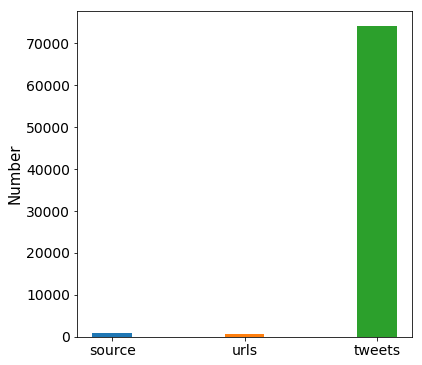

In [97]:
label = ["source", "urls", "tweets"]
plt.figure(figsize=(6, 6))

# plt.subplot(131)

plt.bar(1, len(ira_tweets[ira_tweets["is_source"]==1]), width=0.3)
plt.bar(2, len(ira_source_url), width=0.3)
plt.bar(3, cnt_source, width=0.3)

# label = ["pro-hillary\n{0:.0%}".format(count[0] / (count[0]+count[1])), "pro-trump\n{0:.0%}".format(count[1] / (count[0]+count[1]))]
plt.xticks([1, 2, 3], label)
# plt.xlabel('All users', fontsize=15)
plt.ylabel('Number', fontsize=15)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
# plt.yscale("log")
plt.savefig("fig/ira-source.pdf", dpi=300, bbox_inches='tight')
plt.show()
plt.tight_layout()
plt.close()

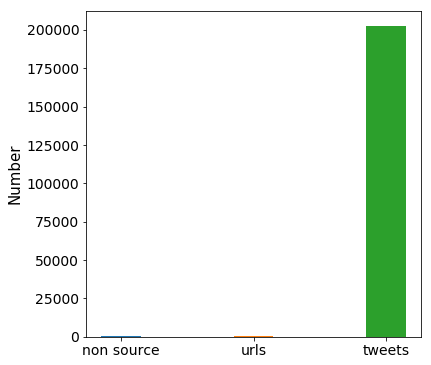

In [98]:
label = ["non source", "urls", "tweets"]
plt.figure(figsize=(6, 6))

# plt.subplot(131)

plt.bar(1, len(ira_tweets[ira_tweets["is_source"]==0]), width=0.3)
plt.bar(2, len(non_source_url), width=0.3)
plt.bar(3, cnt_non, width=0.3)

# label = ["pro-hillary\n{0:.0%}".format(count[0] / (count[0]+count[1])), "pro-trump\n{0:.0%}".format(count[1] / (count[0]+count[1]))]
plt.xticks([1, 2, 3], label)
# plt.xlabel('All users', fontsize=15)
plt.ylabel('Number', fontsize=15)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
# plt.yscale("log")
plt.savefig("fig/ira-source.pdf", dpi=300, bbox_inches='tight')
plt.show()
plt.tight_layout()
plt.close()

In [99]:
len(tweets_csv) / len(tweets_csv["URL"].unique())

13.521723088275989

In [100]:
len(ira_tweets[ira_tweets["is_source"]==1]) / len(ira_source_url)

1.228448275862069

In [101]:
cnt_non / len(non_source_url)

337.34

## IRA的被转发情况

In [102]:
all_tweets = pd.read_csv("data/ira_tweets_csv_hashed.csv", 
                         usecols=["tweetid", "userid", "retweet_count"])

In [104]:
ira_id = set(ira_tweets[ira_tweets["is_source"] == 1]["tweet_id"])
df = all_tweets.loc[all_tweets['tweetid'].isin(ira_id)]
df.describe()

tweetid  retweet_count
count  8.550000e+02     855.000000
mean   7.816363e+17       9.987135
std    1.369839e+16      44.360178
min    7.345768e+17       0.000000
25%    7.769366e+17       0.000000
50%    7.818376e+17       0.000000
75%    7.942575e+17       1.000000
max    7.961374e+17     640.000000

# 用户分析 （Group）

In [20]:
user_count = pd.value_counts(tweets_csv["user_id"]).rename("is_fake")
user_count.head(25)
# type(user_count)

4855687055            8738
4831603043            7334
3374126201            4844
2242085304            4732
122455671             3738
758652815996776448    2956
4906718786            2908
2462473820            2879
750517084166193156    2766
382921457             2707
751963872899305472    2703
1075296265            2605
60893069              2594
759317433345769472    2491
825501626             2476
763982421297553408    2405
707278892801765377    2376
2700350600            2338
746875038901633024    2324
766499969696169984    2321
755614943039352832    2189
3274720530            2169
4857584175            2158
763518863212511232    2136
765648314159210496    2112
Name: is_fake, dtype: int64

## TOP sources

In [21]:
user_sources_count = tweets_csv["is_source"].groupby(tweets_csv["user_id"]).sum().sort_values(ascending=False)
user_sources_count.head(25)

user_id
4855687055            8610
4831603043            7332
3374126201            4844
2242085304            4732
122455671             3738
758652815996776448    2955
2462473820            2878
4906718786            2827
750517084166193156    2766
382921457             2706
751963872899305472    2702
1075296265            2605
60893069              2520
759317433345769472    2486
825501626             2460
763982421297553408    2405
707278892801765377    2376
2700350600            2338
746875038901633024    2324
766499969696169984    2321
755614943039352832    2189
4857584175            2158
763518863212511232    2136
3274720530            2128
765648314159210496    2112
Name: is_source, dtype: int64

In [22]:
user_sources_count["4855687055"]

8610

In [50]:
for uid in user_sources_count.head(25).index:
    try:
        print(uid, winners.index(uid) + 1)
    except:
        print(uid, -1)

4855687055 -1
4831603043 -1
3374126201 -1
2242085304 -1
122455671 -1
758652815996776448 -1
2462473820 -1
4906718786 -1
750517084166193156 -1
382921457 -1
751963872899305472 -1
1075296265 -1
60893069 -1
759317433345769472 -1
825501626 -1
763982421297553408 -1
707278892801765377 -1
2700350600 -1
746875038901633024 -1
766499969696169984 -1
755614943039352832 -1
4857584175 -1
763518863212511232 -1
3274720530 -1
765648314159210496 -1


## TOP first sources

In [23]:
user_first_count = tweets_csv["is_first"].groupby(tweets_csv["user_id"]).sum().sort_values(ascending=False)
user_first_count.head(25)

user_id
122455671             3701
4831603043            2481
60893069              2079
4496549793            1814
825501626             1689
3274720530            1683
3374126201            1565
14210021              1451
137637040             1102
18856867              1085
18208120              1028
138092553              916
634330366              881
112732163              851
359122436              781
1494835716             775
166721424              763
1246177122             759
2270900414             744
3326947147             733
2507996790             708
386235552              682
750517084166193156     679
4578277935             674
466090255              674
Name: is_first, dtype: int64

In [52]:
for uid in user_first_count.head(25).index:
    try:
        print(uid, winners.index(uid) + 1)
    except:
        print(uid, -1)

122455671 -1
4831603043 -1
60893069 -1
4496549793 -1
825501626 -1
3274720530 -1
3374126201 -1
14210021 -1
137637040 -1
18856867 -1
18208120 -1
138092553 -1
634330366 -1
112732163 -1
359122436 -1
1494835716 -1
166721424 -1
1246177122 -1
2270900414 -1
3326947147 -1
2507996790 -1
386235552 -1
750517084166193156 -1
4578277935 -1
466090255 -1


In [33]:
users = pd.concat([user_count, user_first_count, user_sources_count], axis=1, sort=False)
users["source_rate"] = users["is_source"] / users["is_fake"]
users["first_rate"] = users["is_first"] / users["is_fake"]
users["first_source_rate"] = users["is_first"] / users["is_source"]
users = users.fillna(0)
users.head()

is_fake  is_first  is_source  source_rate  first_rate  \
4855687055     8738       327       8610     0.985351    0.037423   
4831603043     7334      2481       7332     0.999727    0.338287   
3374126201     4844      1565       4844     1.000000    0.323080   
2242085304     4732       183       4732     1.000000    0.038673   
122455671      3738      3701       3738     1.000000    0.990102   

            first_source_rate  
4855687055           0.037979  
4831603043           0.338380  
3374126201           0.323080  
2242085304           0.038673  
122455671            0.990102

## 根据Get_User爬虫获取的信息进一步补充users数据项

In [35]:
user_info = pd.DataFrame([json.loads(line.strip()) for line in open("data/fake-users-info.json")])
user_info = user_info.rename(columns={'id_str': 'user_id'})
user_info = user_info.set_index("user_id")

tmp = pd.concat([users, user_info], axis=1, join="inner")
tmp["message"].fillna("User going well.", inplace=True)

In [30]:
tmp.to_csv("data/fake_users.csv")

# 全面分析涉及到的用户特征

In [36]:
users = tmp
# users = pd.read_csv("data/fake_users.csv")

In [45]:
# 用户已经被注销的那些tweets

tweets_csv[tweets_csv["user_id"].isin(users[users["message"]!="User going well."].index)]["tweet_id"].to_csv("data/tweets_id_user_not_found.csv")

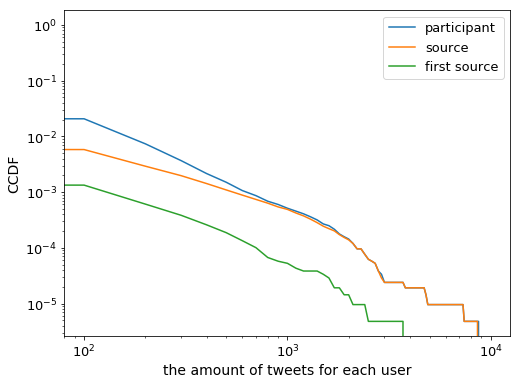

In [303]:
def get_cdf_pdf(data, mini, maxi, step, norm=True):
    x = [float(i) for i in np.arange(mini, maxi, step)]
    cdf = [0] * len(x)
    pdf = [0] * len(x)
    count = 0
    for d in data:
        d = float(d)
        if d < mini or d > maxi:
            continue
        count += 1
        for i in range(len(x)):
            if i == (len(x) - 1) and d >= x[i]:
                pdf[i] += 1
            elif d >= x[i] and d < x[i+1]:
                pdf[i] += 1

            if d >= x[i]:
                cdf[i] += 1

    if norm:
        cdf = [c / count for c in cdf]
        pdf = [p / count for p in pdf]

    return x, cdf, pdf

plt.figure(figsize=(8, 6))
x, cdf, pdf = get_cdf_pdf(users["is_fake"], 0, 10000, 100)
plt.plot(x, cdf, label="participant")
x, cdf, pdf = get_cdf_pdf(users["is_source"], 0, 10000, 100)
plt.plot(x, cdf, label="source")
x, cdf, pdf = get_cdf_pdf(users["is_first"], 0, 10000, 100)
plt.plot(x, cdf, label="first source")
# plt.title('Distribution of size of fake news ', fontsize=15)
plt.ylabel('CCDF', fontsize=14)
plt.xlabel('the amount of tweets for each user', fontsize=14)
plt.xticks(fontsize=13); plt.yticks(fontsize=13)
plt.yscale("log")
plt.xscale("log")
plt.legend(fontsize=13)
plt.savefig('fig/distribution_starters.pdf', dpi=300)
plt.show()
plt.close()

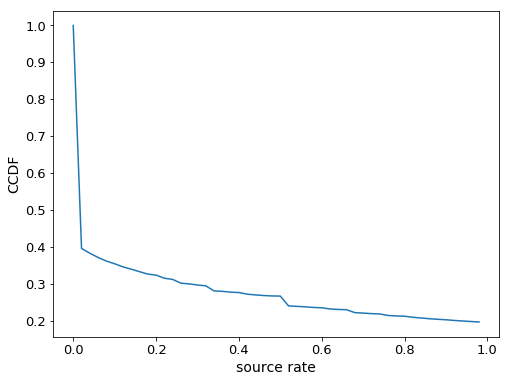

In [294]:
plt.figure(figsize=(8, 6))
x, cdf, pdf = get_cdf_pdf(users["source_rate"], 0, 1, 0.02)
plt.plot(x, cdf)
plt.ylabel('CCDF', fontsize=14)
plt.xlabel('source rate', fontsize=14)
plt.xticks(fontsize=13); plt.yticks(fontsize=13)
# plt.yscale("log"); plt.xscale("log")
plt.savefig('fig/distribution_starters.pdf', dpi=300)
plt.show()
plt.close()

## 用户分类source top500与其他用户

为了研究source users的特点，需要进行对比，目前用户都是跟fake news有关（至少发布一条），选择其他剩余的全部用户作为对比组

In [99]:
top_users = users.sort_values("is_source", ascending=False).head(500)
top_users.to_csv("data/top500-fake-source-users.csv") # save top 500
other_users = users.sort_values("is_source", ascending=False).iloc[500:]

In [101]:
users["is_source_top"] = (users["is_fake"] >= 242)

## 0. 多少用户被suspened，或not found 

In [123]:
prop_df = (users["message"]
           .groupby(users["is_source_top"])
           .value_counts(normalize=True)
           .rename("Prop")
           .reset_index())

In [124]:
prop_df

is_source_top                   message      Prop
0          False          User going well.  0.827816
1          False  User has been suspended.  0.093130
2          False           User not found.  0.079055
3           True          User going well.  0.720036
4           True  User has been suspended.  0.238819
5           True           User not found.  0.041145

In [129]:
users["message"].value_counts()

User going well.            172369
User has been suspended.     19568
User not found.              16430
Name: message, dtype: int64

User going well.            0.827238
User has been suspended.    0.093911
User not found.             0.078851
Name: message, dtype: float64


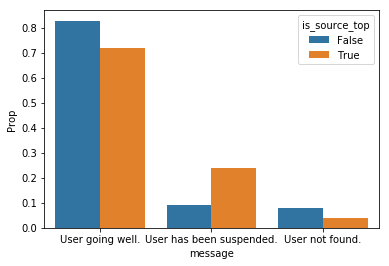

In [125]:
# cnt_not_found = len(users[users["code"]==50]) # 50 not found
# cnt_suspened = len(users[users["code"]==63]) # 63 suspened
# cnt_exists = len(users) - cnt_not_found - cnt_suspened

# height = [cnt_exists, cnt_suspened, cnt_not_found]
# bars = ('exists', 'suspened', 'not found')
# y_pos = np.arange(len(bars))
# plt.xticks(y_pos, bars)
# plt.bar(y_pos, height)

sns.barplot(x="message", y="Prop", data=prop_df, hue="is_source_top")
# users["message"].fillna("User going well.", inplace=True)
print(users["message"].value_counts(normalize=True))

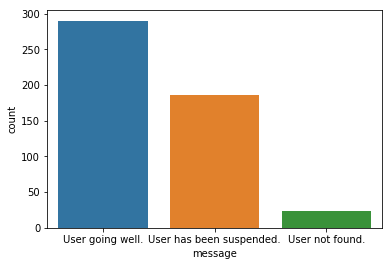

In [130]:
sns.countplot(x="message", data=top_users)

### 检查为什么会存在not found 

<span style="color:red">*已经用账号testkaykaykay进行测试，发现是自己主动deactive the account*</span>

所以suspened和not found的用户在传播过程中是非常重要的，我们不能放过对他们的研究。

In [248]:
uids_not_found = users[users["code"]==50].index

In [255]:
uids_not_found

Index(['137637040', '2711204024', '501567221', '2330112218', '356324005',
       '753082489711816704', '4856642956', '292586544', '4895096885',
       '105604742',
       ...
       '90271735', '734874821759229952', '3053971999', '371334115',
       '154234924', '136617688', '896136019', '2744985801', '307481163',
       '700050080'],
      dtype='object', length=16430)

In [254]:
importlib.reload(SQLite_handler)

<module 'SQLite_handler' from '/home/alex/kayzhou/election/SQLite_handler.py'>

In [256]:
users_data_not_found = SQLite_handler.find_users(uids_not_found)

In [275]:
c = 0
for u in users_data_not_found:
    if "error" in u:
        print(u)
        c += 1
c

{'user_id': '612933174', 'error': 'not found'}
{'user_id': '274551374', 'error': 'not found'}
{'user_id': '3271339802', 'error': 'not found'}
{'user_id': '757449025243131904', 'error': 'not found'}
{'user_id': '706122184985600000', 'error': 'not found'}
{'user_id': '2928819864', 'error': 'not found'}
{'user_id': '4418720713', 'error': 'not found'}
{'user_id': '2201548476', 'error': 'not found'}
{'user_id': '78047698', 'error': 'not found'}


9

In [258]:
users_data_not_found_large = SQLite_handler.find_users_from_large(uids_not_found)

In [273]:
c = 0
for u in users_data_not_found_large:
    if "error" in u:
        c += 1
c

2974

有2974在users.db中没有找到，其中9个用户在alex.db没有找到，可能是IRA

## 1. 地区及语言

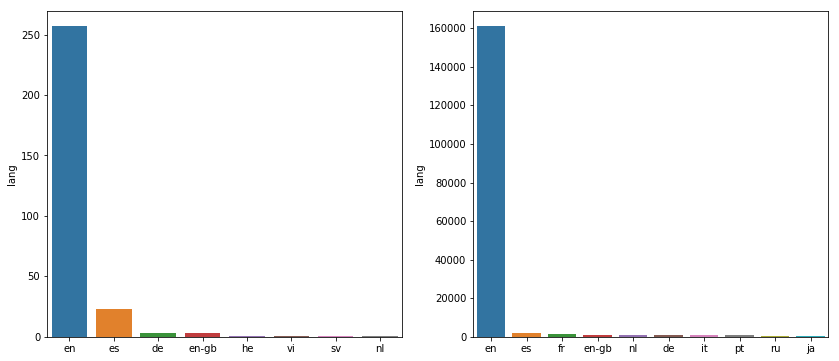

In [138]:
plt.figure(figsize=(14, 6))
plt.subplot(121)
x = top_users.lang.value_counts()[:10]
sns.barplot(x=x.index, y=x)
plt.subplot(122)
x = other_users.lang.value_counts()[:10]
sns.barplot(x=x.index, y=x)

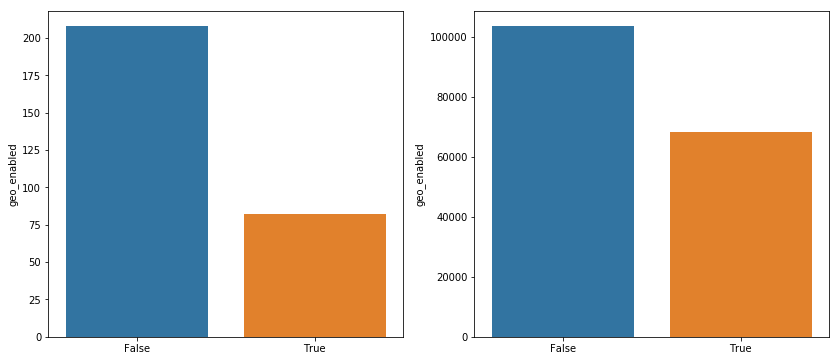

In [142]:
plt.figure(figsize=(14, 6))
plt.subplot(121)
x = top_users.geo_enabled.value_counts()
sns.barplot(x=x.index, y=x)
plt.subplot(122)
x = other_users.geo_enabled.value_counts()
sns.barplot(x=x.index, y=x)

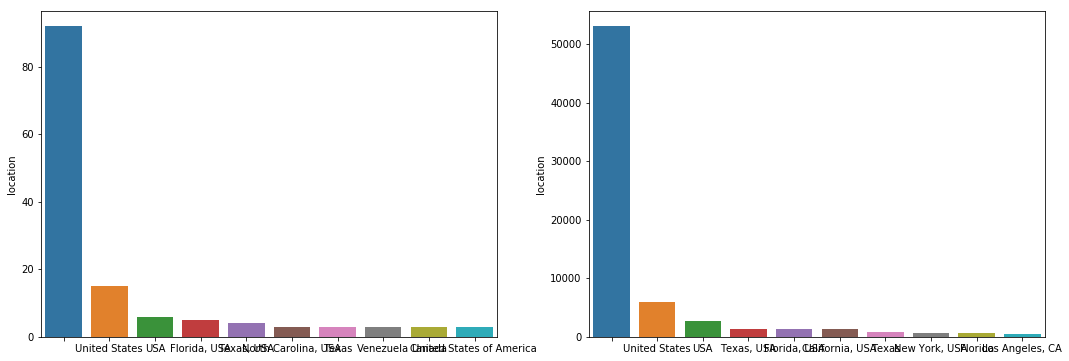

In [146]:
plt.figure(figsize=(18, 6))
plt.subplot(121)
x = top_users.location.value_counts()[:10]
# print(top_users.location.value_counts())
sns.barplot(x=x.index, y=x)
plt.subplot(122)
x = other_users.location.value_counts()[:10]
# print(other_users.location.value_counts())
sns.barplot(x=x.index, y=x)

# 2. 是否为验证用户 

False    288
True       2
Name: verified, dtype: int64
False    171331
True        748
Name: verified, dtype: int64


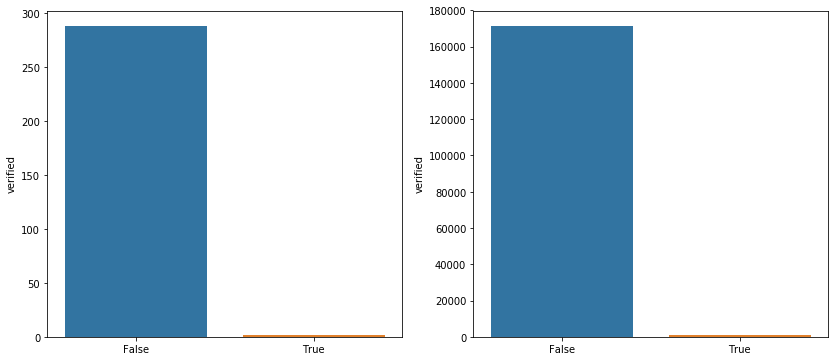

In [148]:
plt.figure(figsize=(14, 6))
plt.subplot(121)
x = top_users.verified.value_counts()
print(x)
sns.barplot(x=x.index, y=x)
plt.subplot(122)
x = other_users.verified.value_counts()
print(x)
sns.barplot(x=x.index, y=x)

In [310]:
top_users = users.sort_values("is_source", ascending=False).head(500)
top_users.to_csv("data/top-fake-source-users.csv") # save top 500

# 3. fake news指标上的数值

In [307]:
top_users.describe()

is_fake     is_first    is_source  source_rate  first_rate  \
count   500.000000   500.000000   500.000000   500.000000  500.000000   
mean    762.926000   169.300000   735.654000     0.960769    0.236179   
std     774.666688   317.297238   770.916332     0.096048    0.296095   
min     242.000000     0.000000   242.000000     0.158537    0.000000   
25%     352.750000    18.000000   326.500000     0.974556    0.031736   
50%     495.500000    60.000000   463.000000     1.000000    0.101484   
75%     868.750000   189.250000   832.250000     1.000000    0.308026   
max    8738.000000  3701.000000  8610.000000     1.000000    1.000000   

       first_source_rate        code  favourites_count  followers_count  \
count         500.000000  210.000000        290.000000       290.000000   
mean            0.243625   61.452381      19108.682759     19948.996552   
std             0.300387    4.220039      39534.300396     70624.566055   
min             0.000000   50.000000          0.000000        22.000000   
25%             0.035021   63.000000         24.500000       853.000000   
50%             0.105237   63.000000       1546.000000      4226.000000   
75%             0.319565   63.000000      21422.500000     14281.500000   
max             1.000000   63.000000     443492.000000    929739.000000   

       friends_count            id  listed_count  statuses_count  time_zone  \
count     290.000000  5.000000e+02    290.000000    2.900000e+02        0.0   
mean    10876.831034  2.382561e+17    273.306897    1.508388e+05        NaN   
std     29152.609896  3.526803e+17   1075.046048    1.835696e+05        NaN   
min         0.000000  1.267113e+07      0.000000    0.000000e+00        NaN   
25%       550.250000  1.978720e+08     30.250000    4.066850e+04        NaN   
50%      2961.000000  2.222342e+09     97.500000    9.859950e+04        NaN   
75%      9325.000000  7.512894e+17    232.500000    1.787560e+05        NaN   
max    367616.000000  7.909311e+17  16015.000000    1.045437e+06        NaN   

       utc_offset  
count         0.0  
mean          NaN  
std           NaN  
min           NaN  
25%           NaN  
50%           NaN  
75%           NaN  
max           NaN

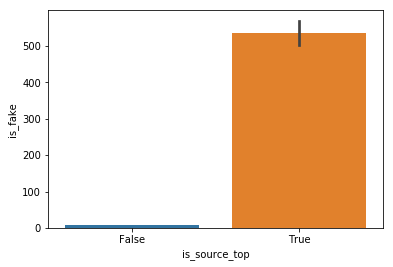

In [153]:
sns.barplot(x="is_source_top", y="is_fake", data=users, estimator=np.mean)

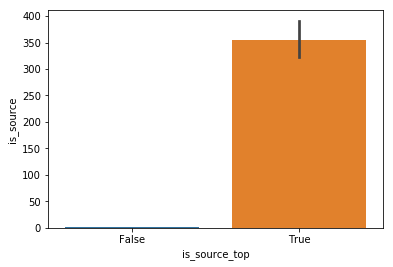

In [154]:
sns.barplot(x="is_source_top", y="is_source", data=users, estimator=np.mean)

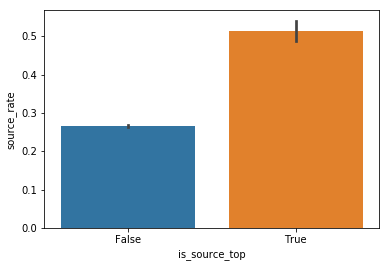

In [163]:
sns.barplot(x="is_source_top", y="source_rate", data=users, estimator=np.mean)

# 4. 基本统计数据上的数值

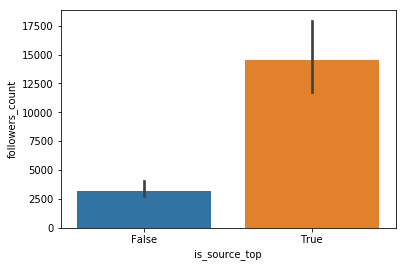

In [156]:
sns.barplot(x="is_source_top", y="followers_count", data=users, estimator=np.mean)

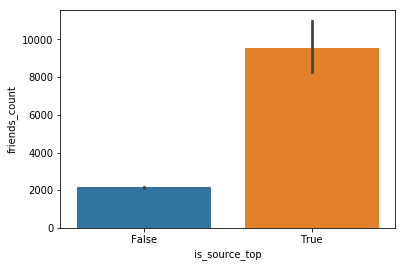

In [158]:
sns.barplot(x="is_source_top", y="friends_count", data=users, estimator=np.mean)

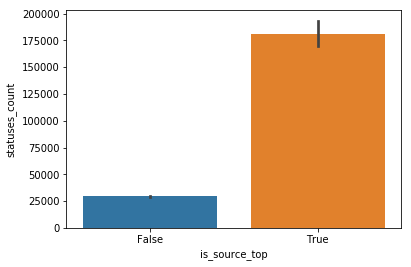

In [159]:
sns.barplot(x="is_source_top", y="statuses_count", data=users, estimator=np.mean)

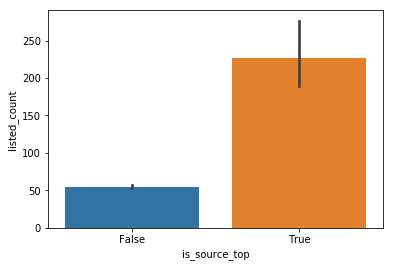

In [160]:
sns.barplot(x="is_source_top", y="listed_count", data=users, estimator=np.mean)

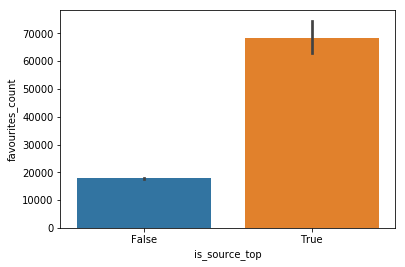

In [162]:
sns.barplot(x="is_source_top", y="favourites_count", data=users, estimator=np.mean)

# 5. CI与source的关系

In [22]:
f_labels = ["FAKE", "BIAS", "LEFT", "LEFTCENTER", "CENTER", "RIGHTCENTER", "RIGHT"]

In [23]:
node_map = json.load(open("disk/node_map.json"))

FAKE ...
BIAS ...
LEFT ...
LEFTCENTER ...
CENTER ...
RIGHTCENTER ...
RIGHT ...


{'FAKE': 346,
 'BIAS': 349,
 'LEFT': 248,
 'LEFTCENTER': 162,
 'CENTER': 159,
 'RIGHTCENTER': 151,
 'RIGHT': 241}

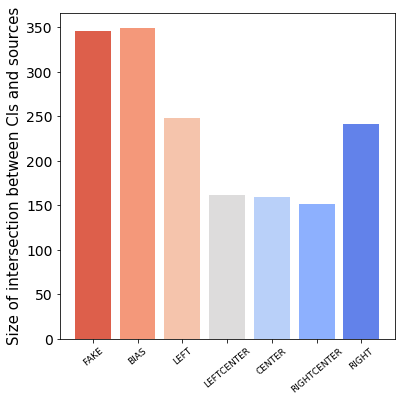

In [189]:
pea_source_cnt_CI_rank = {}
spe_source_cnt_CI_rank = {}
pea_source_cnt_CI_value = {}
spe_source_cnt_CI_value = {}

pea_first_cnt_CI_rank = {}
spe_first_cnt_CI_rank = {}
pea_first_cnt_CI_value = {}
spe_first_cnt_CI_value = {}

top_num = 1000

len_intersection = {}

for label in f_labels:
    print(label, "...")
    CI_rst = np.load("data/CI_rst/CI_out_{}.npy".format(label))
    CI_rank_rst = CI_rst[0][:top_num]
    # print(CI_rank_rst)
    CI_values_rst = CI_rst[1]
    
    CI_index = []
    CI_rank_values = []
    CI_values = []

    users = pd.read_csv("data/users_{}.csv".format(label), dtype=str, nrows=top_num)
    users = users.astype({"cnt": int, "source_cnt": int, "first_cnt": int, 
                          "source_rate": float, "first_rate": float, "first_source_rate": float})
    users = users.set_index("user_id")
    # print(users)
    
    set_CI_users = set(CI_rank_rst)
    set_source_users = set()
    
    for user_id, row in users.iterrows():
        node_id = node_map[user_id]
        set_source_users.add(node_id)
        try:
            i = CI_rank_rst.index(node_id)
            rank = top_num - i
        except ValueError as e:
            rank = 0

        val = CI_values_rst[node_id]
        # print("->", user_id, rank, val)
        CI_index.append(user_id)
        CI_rank_values.append(rank)
        CI_values.append(val)

    len_intersection[label] = len(set_CI_users & set_source_users)
        
    CI_rank = pd.Series(CI_rank_values, index=CI_index)
    CI_values = pd.Series(CI_values, index=CI_index)
    users["CI_rank"] = pd.Series(CI_rank)
    users["CI_values"] = pd.Series(CI_values)
    
    source_CI = pd.DataFrame({
                              "CI_rank": users["CI_rank"],
                              "CI_values": users["CI_values"],
                              "cnt": users["cnt"],
                              "source_cnt": users["source_cnt"],
                              "first_cnt": users["first_cnt"],
                              "source_rate": users["source_rate"]}
                            )
    
#     print("pearson ~")
    cor = source_CI.corr(method="pearson")
#     display(cor)
    pea_source_cnt_CI_rank[label] = cor.source_cnt["CI_rank"]
    pea_source_cnt_CI_value[label] = cor.source_cnt["CI_values"]
    
#     print("spearman ~")
    cor = source_CI.corr(method="spearman")
#     display(cor)
    spe_source_cnt_CI_rank[label] = cor.source_cnt["CI_rank"]
    spe_source_cnt_CI_value[label] = cor.source_cnt["CI_values"]
    
#     print("pearson ~")
    cor = source_CI.corr(method="pearson")
#     display(cor)
    pea_first_cnt_CI_rank[label] = cor.first_cnt["CI_rank"]
    pea_first_cnt_CI_value[label] = cor.first_cnt["CI_values"]
    
#     print("spearman ~")
    cor = source_CI.corr(method="spearman")
#     display(cor)
    spe_first_cnt_CI_rank[label] = cor.first_cnt["CI_rank"]
    spe_first_cnt_CI_value[label] = cor.first_cnt["CI_values"]
    
def plot_corr(cor):
    display(cor)
    plt.figure(figsize=(6, 6))
    x = range(len(f_labels))
    for i in x:
        plt.bar(i, cor[f_labels[i]], color=sns.color_palette("coolwarm", 7)[6-i])
    plt.xticks(x, f_labels)
#     plt.xlabel('Only IRA', fontsize=15)
    plt.ylabel('Size of intersection between CIs and sources', fontsize=15)
    plt.xticks(fontsize=9, rotation=40); plt.yticks(fontsize=14)
    plt.savefig("fig/size-of-intersection500.pdf", dpi=300, bbox_inches='tight')
    plt.show()
    plt.tight_layout()
    plt.close()
    
# plot_corr(pea_source_cnt_CI_rank)
# plot_corr(spe_source_cnt_CI_rank)
# plot_corr(pea_source_cnt_CI_value)
# plot_corr(spe_source_cnt_CI_value)

plot_corr(len_intersection)

# # plot_corr(pea_source_cnt_CI_rank)
# plot_corr(spe_first_cnt_CI_rank)
# # plot_corr(pea_source_cnt_CI_value)
# plot_corr(spe_first_cnt_CI_value)


/home/alex/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


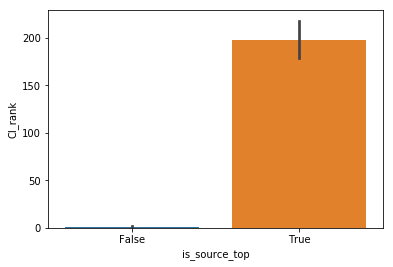

In [300]:
sns.barplot(x="is_source_top", y="CI_rank", data=users, estimator=np.mean)

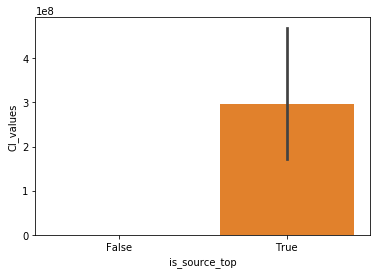

In [301]:
sns.barplot(x="is_source_top", y="CI_values", data=users, estimator=np.mean)

In [302]:
source_CI = pd.DataFrame({"CI_rank": users["CI_rank"],
                          "CI_values": users["CI_values"],
                          "is_source": users["is_source"],
                          "source_rate": users["source_rate"]})

In [303]:
source_CI.corr()

CI_rank  CI_values  is_source  source_rate
CI_rank      1.000000   0.257452   0.488942     0.082084
CI_values    0.257452   1.000000   0.328691     0.016954
is_source    0.488942   0.328691   1.000000     0.109910
source_rate  0.082084   0.016954   0.109910     1.000000

In [304]:
# 顺便这里把IRA做一下

ira_users = users.loc[ira_tweets["user_id"].unique()]

In [305]:
ira_users[ira_users["CI_rank"] > 0]

is_fake  is_first  is_source  source_rate  first_rate  \
4437444442                5         0          5     1.000000    0.000000   
4272870988               23         3         22     0.956522    0.130435   
4224729994               18         9         17     0.944444    0.500000   
4289431230                5         0          5     1.000000    0.000000   
4355797094                6         1          6     1.000000    0.166667   
789266125485998080      223        29        223     1.000000    0.130045   
4311371968               11         2         10     0.909091    0.181818   

                    first_source_rate  code contributors_enabled created_at  \
4437444442                   0.000000  63.0                  NaN        NaN   
4272870988                   0.136364  63.0                  NaN        NaN   
4224729994                   0.529412  63.0                  NaN        NaN   
4289431230                   0.000000  63.0                  NaN        NaN   
4355797094                   0.166667  63.0                  NaN        NaN   
789266125485998080           0.130045  63.0                  NaN        NaN   
4311371968                   0.200000  63.0                  NaN        NaN   

                   default_profile    ...    statuses_count time_zone  \
4437444442                     NaN    ...               NaN       NaN   
4272870988                     NaN    ...               NaN       NaN   
4224729994                     NaN    ...               NaN       NaN   
4289431230                     NaN    ...               NaN       NaN   
4355797094                     NaN    ...               NaN       NaN   
789266125485998080             NaN    ...               NaN       NaN   
4311371968                     NaN    ...               NaN       NaN   

                   translator_type  url utc_offset  verified  \
4437444442                     NaN  NaN        NaN       NaN   
4272870988                     NaN  NaN        NaN       NaN   
4224729994                     NaN  NaN        NaN       NaN   
4289431230                     NaN  NaN        NaN       NaN   
4355797094                     NaN  NaN        NaN       NaN   
789266125485998080             NaN  NaN        NaN       NaN   
4311371968                     NaN  NaN        NaN       NaN   

                   withheld_in_countries  is_source_top CI_rank CI_values  
4437444442                           NaN          False     305   3486230  
4272870988                           NaN          False     606  19000410  
4224729994                           NaN          False     717  45916704  
4289431230                           NaN          False     342   4104793  
4355797094                           NaN          False     320   3662592  
789266125485998080                   NaN          False      92   1299480  
4311371968                           NaN          False     385   5149200  

[7 rows x 55 columns]

In [291]:
ira_users.describe()

is_fake   is_first   is_source  source_rate  first_rate  \
count   92.000000  92.000000   92.000000    92.000000   92.000000   
mean    17.706522   3.739130    9.336957     0.537902    0.174323   
std     40.342092   8.527743   26.549261     0.369736    0.242284   
min      1.000000   0.000000    0.000000     0.000000    0.000000   
25%      1.000000   0.000000    1.000000     0.279720    0.000000   
50%      4.000000   1.000000    2.000000     0.500000    0.102302   
75%     15.500000   2.250000    7.000000     1.000000    0.254332   
max    228.000000  54.000000  223.000000     1.000000    1.000000   

       first_source_rate  code  favourites_count  followers_count  \
count          92.000000  92.0               0.0              0.0   
mean                 inf  63.0               NaN              NaN   
std                  NaN   0.0               NaN              NaN   
min             0.000000  63.0               NaN              NaN   
25%             0.000000  63.0               NaN              NaN   
50%             0.183333  63.0               NaN              NaN   
75%             0.582543  63.0               NaN              NaN   
max                  inf  63.0               NaN              NaN   

       friends_count            id  listed_count  statuses_count  time_zone  \
count            0.0  9.200000e+01           0.0             0.0        0.0   
mean             NaN  4.026391e+16           NaN             NaN        NaN   
std              NaN  1.690001e+17           NaN             NaN        NaN   
min              NaN  1.513801e+09           NaN             NaN        NaN   
25%              NaN  1.671006e+09           NaN             NaN        NaN   
50%              NaN  2.492015e+09           NaN             NaN        NaN   
75%              NaN  2.932521e+09           NaN             NaN        NaN   
max              NaN  7.892661e+17           NaN             NaN        NaN   

       utc_offset    CI_rank     CI_values  
count         0.0   92.00000  9.200000e+01  
mean          NaN   15.50000  2.367963e+06  
std           NaN   84.76775  1.469957e+07  
min           NaN    0.00000  0.000000e+00  
25%           NaN    0.00000  0.000000e+00  
50%           NaN    0.00000  0.000000e+00  
75%           NaN    0.00000  0.000000e+00  
max           NaN  620.00000  1.295445e+08

In [293]:
## 明天把数据都补充上！这下就更牛逼了！

___
# Analysis of results of all_tweets.py

In [2]:
from all_tweets import ALL_TWEET

Lebron = ALL_TWEET()
Lebron.load_all_tweets()
all_tweets = Lebron.tweets_csv

In [3]:
all_tweets.head()

URL                   dt  \
0  http://www.newsweek.com/vladimir-putin-sidney-...  2016-10-10 18:49:57   
1  http://www.newsweek.com/vladimir-putin-sidney-...  2016-10-10 18:50:09   
2  http://www.newsweek.com/vladimir-putin-sidney-...  2016-10-10 18:50:10   
3  http://www.newsweek.com/vladimir-putin-sidney-...  2016-10-10 18:50:16   
4  http://www.newsweek.com/vladimir-putin-sidney-...  2016-10-10 18:50:23   

       hostname  is_IRA  is_first  is_source media_type        retweeted_id  \
0  newsweek.com       0         1          1          5                   0   
1  newsweek.com       0         0          0          5  785628468746727424   
2  newsweek.com       0         0          0          5  785628468746727424   
3  newsweek.com       0         0          0          5  785628468746727424   
4  newsweek.com       0         0          0          5  785628468746727424   

             tweet_id             user_id  
0  785628468746727424           215207998  
1  785628515991302144            20634939  
2  785628519703326722            26378513  
3  785628546114859008           445966346  
4  785628574388621312  754104364164345860

In [4]:
map_labels = {
    "0": "fake",
    "1": "extreme bias (right)",
    "2": "right",
    "3": "right leaning",
    "4": "center",
    "5": "left leaning",
    "6": "left",
    "7": "extreme bias (left)"
}

5    0.248073
4    0.202138
6    0.138035
2    0.132540
1    0.129961
0    0.096489
3    0.033992
7    0.018773
Name: media_type, dtype: float64

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 ]),
 <a list of 7 Text yticklabel objects>)

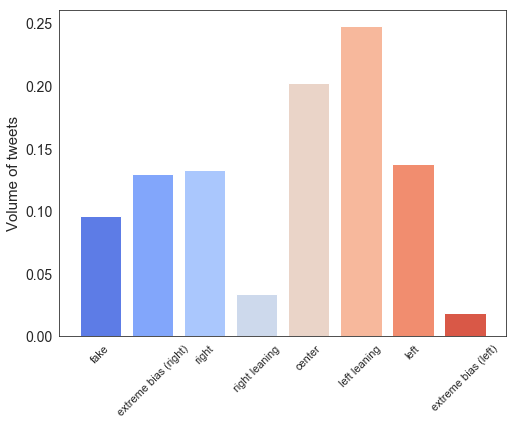

In [5]:
sns.set_style("white")
sns.set_palette("coolwarm", n_colors=8)

media_type_counts = all_tweets["media_type"].value_counts(normalize=True)
display(media_type_counts)
plt.figure(figsize=(8, 6))
x = range(len(media_type_counts))

for i in x:
    plt.bar(i, media_type_counts[str(i)])
    
plt.xticks(x, [map_labels[k] for i, k in enumerate(map_labels)])
# plt.xlabel("IRAs", fontsize=18)
plt.ylabel('Volume of tweets', fontsize=15)
plt.xticks(fontsize=11, rotation=45)
plt.yticks(fontsize=14)

# plt.savefig("fig/size-of-intersection500.pdf", dpi=300, bbox_inches='tight')

In [6]:
IRA_tweets = all_tweets[all_tweets["is_IRA"]>0]

## Loading all-users.csv ... ...

!! Already coded in the all_tweets.py for making all-users.csv

In [10]:
def load_all_users():
    users = pd.read_csv("data/all-users.csv", index_col="user_id", dtype={"user_id": str})

    # change the type
    f_labels = [map_labels[k] for k in map_labels]
    users = users.astype({"is_IRA": int})

    for label in f_labels:
        users = users.astype({label: int, label + "_source": int, label + "_first": int, 
                              label + "_source_rate": float, label + "_first_rate": float,
                              label + "_first_source_rate": float,})
    return users

In [12]:
all_users = load_all_users()

In [305]:
# user_id > name

user_info = pd.DataFrame([json.loads(line.strip()) for line in open("data/user-top-info.json")])
user_info = user_info.rename(columns={'id_str': 'user_id'})
user_info = user_info.set_index("user_id")
map_user_name = []
for line in open("data/user-top-info.json"):
    d = json.loads(line.strip())
    try:
        dat = {"user_id": d["id_str"], "name": d["name"]}
    except:
        dat = {"user_id": d["id_str"], "name": d["message"]}
    map_user_name.append(dat)
    
map_user_name = pd.DataFrame(map_user_name).set_index("user_id")

In [307]:
# Show the top sources !!!

for label in f_labels:
    print(label)
    tmp = users.sort_values(label + "_source", ascending=False).head(25)
    tmp = tmp.join(map_user_name)
#     display(tmp)
#     display(tmp[[label + "_source", "name"]].sort_values(label + "_source", ascending=False))
    

FAKE
BIAS
LEFT
LEFTCENTER
CENTER
RIGHTCENTER
RIGHT


## Are IRAs the sources of fake news or influencers? 

In [14]:
len(IRA_tweets)

7343

In [15]:
IRA_users = all_users[all_users.is_IRA > 0]
len(IRA_users)

266

In [17]:
other_users = all_users[all_users.is_IRA == 0]

0 1205
1 1559
2 1261
3 222
4 1670
5 1014
6 736
7 96
0 3311046
1 4459724
2 4548549
3 1166666
4 6937293
5 8514810
6 4737724
7 644352


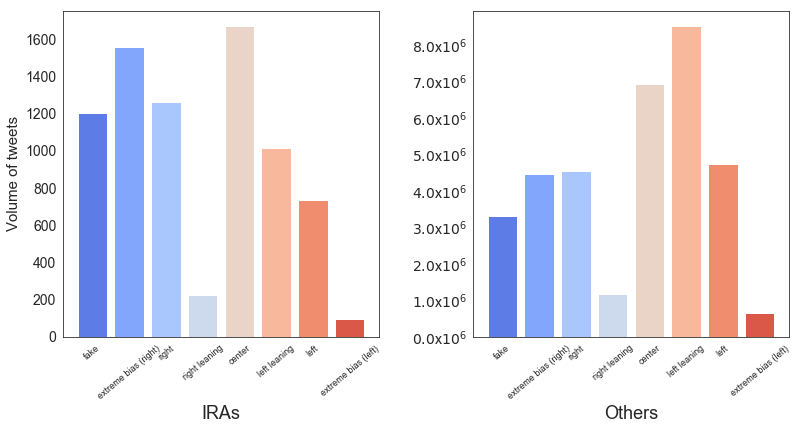

In [18]:
from matplotlib.ticker import FuncFormatter

plt.figure(figsize=(13, 6))
plt.subplots_adjust(wspace = 0.3)
ax = plt.subplot(121)
x = range(len(media_type_counts))

for i in x:
#     d = IRA_users[map_labels[str(i)]].sum()
    print(i, IRA_users[map_labels[str(i)]].sum())
    plt.bar(i, IRA_users[map_labels[str(i)]].sum())

plt.xticks(x, [map_labels[k] for i, k in enumerate(map_labels)])
plt.xlabel("IRAs", fontsize=18)
plt.ylabel('Volume of tweets', fontsize=15)
plt.xticks(fontsize=9, rotation=40)
plt.yticks(fontsize=14)
# plt.savefig("fig/size-of-intersection500.pdf", dpi=300, bbox_inches='tight')

ax = plt.subplot(122)
x = range(len(media_type_counts))

for i in x:
    print(i, other_users[map_labels[str(i)]].sum())
    plt.bar(i, other_users[map_labels[str(i)]].sum())
    
plt.xticks(x, [map_labels[k] for i, k in enumerate(map_labels)])
plt.xlabel("Others", fontsize=18)
# plt.ylabel('Source rate of tweets of all users', fontsize=15)
plt.xticks(fontsize=9, rotation=40)
plt.yticks(fontsize=14)

def formatnum(x, pos):
    return '$%.1f$x$10^{6}$' % (x/1000000)
formatter = FuncFormatter(formatnum)
ax.yaxis.set_major_formatter(formatter)

plt.show()
plt.tight_layout()
plt.savefig("fig/IRA Volume.pdf", dpi=300, bbox_inches='tight')
plt.close()

## 用户角度 

making the big table!!

In [242]:
def get_big_table(_users):
    big_table = []

    for i in range(len(map_labels)):
        lab = map_labels[str(i)]
        volume = _users[lab].sum()
        source_volume = _users[lab + "_source"].sum()
        first_volume = _users[lab + "_first"].sum()
        source_rate = _users[_users[lab + "_source_rate"] > 0][lab + "_source_rate"].mean()
        first_rate = _users[_users[lab + "_first_rate"] > 0][lab + "_first_rate"].mean()
        user_volume = len(_users[_users[lab]>0])
        source_user_volume = len(_users[_users[lab + "_source"]>0])
        d = dict(Nt=volume, Ns=source_volume, Nu=user_volume,
                 Rs=source_rate, Rf=first_rate, Nsu=source_user_volume, Nf=first_volume)
        big_table.append(d)

    big_table = pd.DataFrame(big_table, index=[map_labels[k] for k in map_labels])
    big_table["Pt"] = big_table["Nt"] / big_table["Nt"].sum()
    big_table["Ps"] = big_table["Ns"] / big_table["Ns"].sum()
    big_table["Ns/Nt"] = big_table["Ns"] / big_table["Nt"]
    big_table["Nf/Nt"] = big_table["Nf"] / big_table["Nt"]
    big_table["Nt/Nu"] = big_table["Nt"] / big_table["Nu"]
    big_table["Ns/Nsu"] = big_table["Ns"] / big_table["Nsu"]

    big_table = big_table[["Nt", "Pt", "Ns", "Ns/Nt", "Ps", "Rs", "Nu", "Nt/Nu", "Nsu", "Ns/Nsu"]]
#     big_table = big_table[["Nt", "Pt", "Ns", "Ps", "Ns/Nt", "Nu", "Rs", "Rf", "Nt/Nu"]]
    return big_table

In [243]:
BT = get_big_table(IRA_users)
BT.to_csv("data/IRA_BT.csv", float_format="%.2f")
BT

Nt        Pt   Ns     Ns/Nt        Ps        Rs   Nu  \
fake                  1205  0.155223  311  0.258091  0.214483  0.659598   72   
extreme bias (right)  1559  0.200824  139  0.089160  0.095862  0.627011   97   
right                 1261  0.162437  229  0.181602  0.157931  0.743776  104   
right leaning          222  0.028597   42  0.189189  0.028966  0.812037   83   
center                1670  0.215123  159  0.095210  0.109655  0.605829  169   
left leaning          1014  0.130620  462  0.455621  0.318621  0.796495  174   
left                   736  0.094809   93  0.126359  0.064138  0.627175  151   
extreme bias (left)     96  0.012366   15  0.156250  0.010345  0.708664   42   

                          Nt/Nu  Nsu     Ns/Nsu  
fake                  16.736111   26  11.961538  
extreme bias (right)  16.072165   32   4.343750  
right                 12.125000   41   5.585366  
right leaning          2.674699   18   2.333333  
center                 9.881657   44   3.613636  
left leaning           5.827586   39  11.846154  
left                   4.874172   39   2.384615  
extreme bias (left)    2.285714   12   1.250000

In [244]:
BT.Nt.sum()

7763

In [245]:
BT2 = get_big_table(all_users)
BT2.to_csv("data/all_BT.csv", float_format="%.2f")
BT2

Nt        Pt       Ns     Ns/Nt        Ps  \
fake                  3312251  0.096489  1153670  0.348304  0.106597   
extreme bias (right)  4461283  0.129961  1288685  0.288860  0.119072   
right                 4549810  0.132540  1259870  0.276906  0.116409   
right leaning         1166888  0.033992   396054  0.339410  0.036595   
center                6938963  0.202138  2250428  0.324318  0.207935   
left leaning          8515824  0.248073  2588437  0.303956  0.239166   
left                  4738460  0.138035  1700246  0.358818  0.157099   
extreme bias (left)    644448  0.018773   185380  0.287657  0.017129   

                            Rs       Nu      Nt/Nu     Nsu     Ns/Nsu  
fake                  0.617579   214315  15.455059   83113  13.880741  
extreme bias (right)  0.647921   309703  14.405036  114131  11.291279  
right                 0.680517   446382  10.192638  162860   7.735908  
right leaning         0.798494   303666   3.842669   98531   4.019588  
center                0.724414  1116958   6.212376  348501   6.457451  
left leaning          0.729262  1383946   6.153292  467853   5.532586  
left                  0.764568   713033   6.645499  262903   6.467199  
extreme bias (left)   0.784213   103730   6.212745   38972   4.756748

In [246]:
def plot_compare(col_name):
    ax = plt.figure(figsize=(10, 6))
    plt.ylabel(col_name, fontsize=15)
    plt.xlabel("IRAs", fontsize=15)
    print(BT[col_name])
    print(BT2[col_name])
    BT[col_name].plot.bar(width=0.3, position=0, color=sns.color_palette("coolwarm", 8)[7], label="IRAs")
    BT2[col_name].plot.bar(width=0.3, position=1, color=sns.color_palette("coolwarm", 8)[0], label="All users")
    plt.xlabel("All users", fontsize=15)
    
    plt.xlim(-1, 8)
    
#     if col_name == "Ns/Nt":
#         plt.ylim((0, 0.5))
#     if col_name == "Rs":
#         plt.ylim((0, 0.15))
#     if col_name == "Rf":
#         plt.ylim((0, 0.08))
    
    plt.legend(fontsize=13)
    plt.show()
    plt.close()

fake                    0.155223
extreme bias (right)    0.200824
right                   0.162437
right leaning           0.028597
center                  0.215123
left leaning            0.130620
left                    0.094809
extreme bias (left)     0.012366
Name: Pt, dtype: float64
fake                    0.096489
extreme bias (right)    0.129961
right                   0.132540
right leaning           0.033992
center                  0.202138
left leaning            0.248073
left                    0.138035
extreme bias (left)     0.018773
Name: Pt, dtype: float64


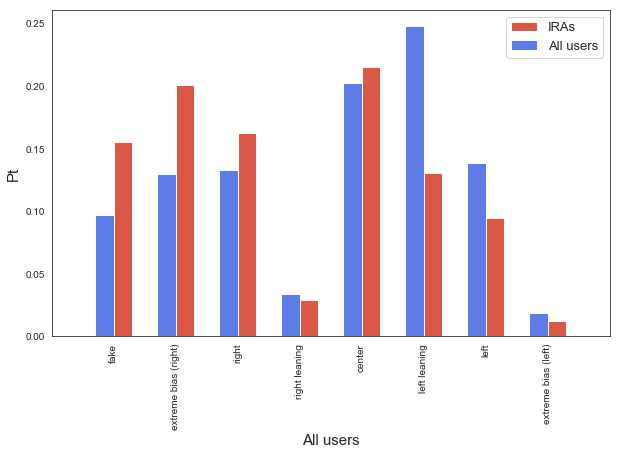

In [247]:
plot_compare("Pt")

fake                    0.659598
extreme bias (right)    0.627011
right                   0.743776
right leaning           0.812037
center                  0.605829
left leaning            0.796495
left                    0.627175
extreme bias (left)     0.708664
Name: Rs, dtype: float64
fake                    0.617579
extreme bias (right)    0.647921
right                   0.680517
right leaning           0.798494
center                  0.724414
left leaning            0.729262
left                    0.764568
extreme bias (left)     0.784213
Name: Rs, dtype: float64


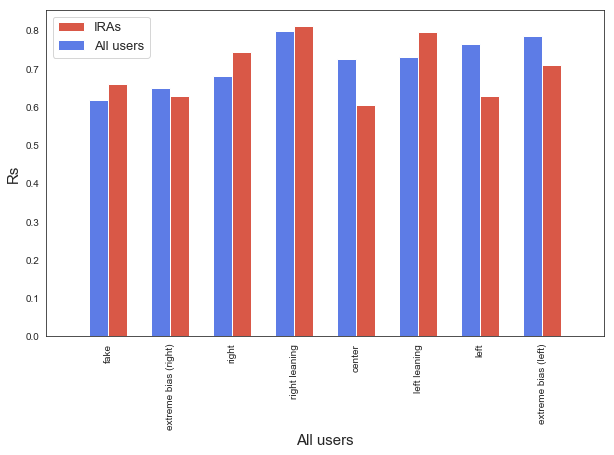

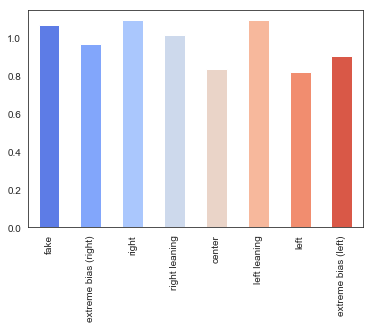

In [248]:
plot_compare("Rs")
(BT["Rs"] / BT2["Rs"]).plot.bar()

fake                    16.736111
extreme bias (right)    16.072165
right                   12.125000
right leaning            2.674699
center                   9.881657
left leaning             5.827586
left                     4.874172
extreme bias (left)      2.285714
Name: Nt/Nu, dtype: float64
fake                    15.455059
extreme bias (right)    14.405036
right                   10.192638
right leaning            3.842669
center                   6.212376
left leaning             6.153292
left                     6.645499
extreme bias (left)      6.212745
Name: Nt/Nu, dtype: float64


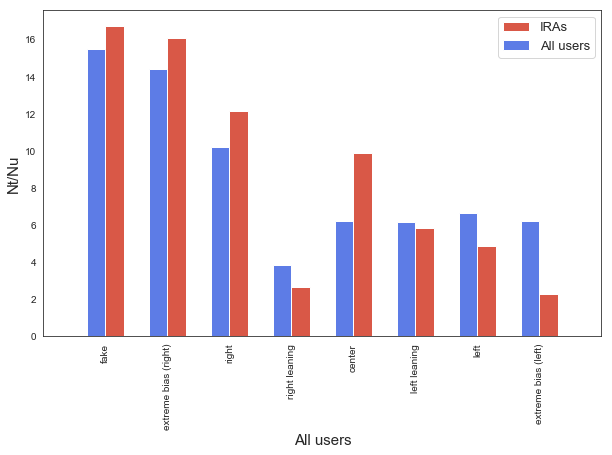

In [250]:
plot_compare("Nt/Nu")

fake                    11.961538
extreme bias (right)     4.343750
right                    5.585366
right leaning            2.333333
center                   3.613636
left leaning            11.846154
left                     2.384615
extreme bias (left)      1.250000
Name: Ns/Nsu, dtype: float64
fake                    13.880741
extreme bias (right)    11.291279
right                    7.735908
right leaning            4.019588
center                   6.457451
left leaning             5.532586
left                     6.467199
extreme bias (left)      4.756748
Name: Ns/Nsu, dtype: float64


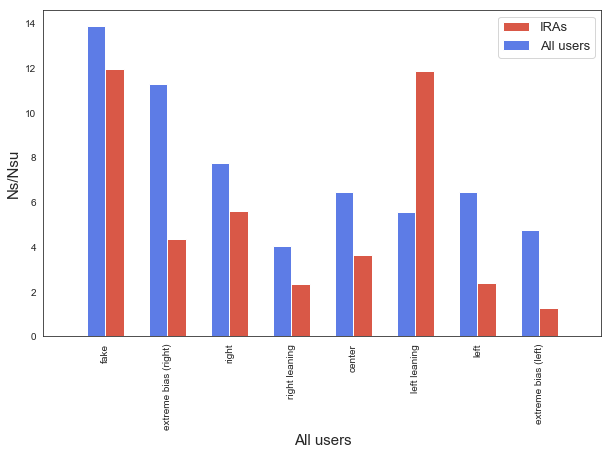

In [251]:
plot_compare("Ns/Nsu")

## IRAs as sources

1. 看看每个用户发布的量
2. 找到top sources看看交集

结论：IRA从量上来看伪装非常普通的用户！

fake


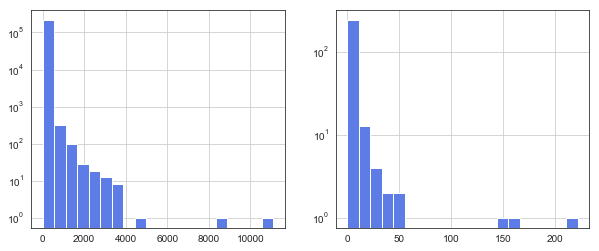

extreme bias (right)
right
right leaning
center
left leaning
left
extreme bias (left)


count       mean        std  min  25%  50%  75%  \
fake                   214315.0  15.455059  78.441195  1.0  1.0  2.0  7.0   
extreme bias (right)   309703.0  14.405036  79.152552  1.0  1.0  2.0  6.0   
right                  446382.0  10.192638  53.830462  1.0  1.0  1.0  4.0   
right leaning          303666.0   3.842669  16.635857  1.0  1.0  1.0  3.0   
center                1116958.0   6.212376  50.542915  1.0  1.0  1.0  3.0   
left leaning          1383946.0   6.153292  35.481755  1.0  1.0  1.0  3.0   
left                   713033.0   6.645499  41.781824  1.0  1.0  1.0  3.0   
extreme bias (left)    103730.0   6.212745  26.939494  1.0  1.0  1.0  3.0   

                          max  
fake                  11099.0  
extreme bias (right)  19343.0  
right                 15863.0  
right leaning          3366.0  
center                35043.0  
left leaning           8693.0  
left                   6051.0  
extreme bias (left)    2761.0

In [105]:
sns.set_style("white")

USER_TABLE = {}

for i in range(len(map_labels)):
    lab = map_labels[str(i)]
    print(lab)
    
    plt.figure(figsize=(10, 4))
    ax = plt.subplot(121)
    _users = all_users[all_users[lab] > 0]
    _users[lab].hist(ax=ax, bins=20)
    
    # display(all_users[lab + "_source"].describe())
    USER_TABLE[lab] = _users[lab].describe()
    plt.yscale("log")
#     plt.xscale("log")
    
    ax = plt.subplot(122)
    IRA_users[lab].hist(ax=ax, bins=20)
    plt.yscale("log")
    
    if lab == "fake":
        plt.show()
    plt.close()

    
USER_TABLE = pd.DataFrame(USER_TABLE).transpose()
USER_TABLE

fake


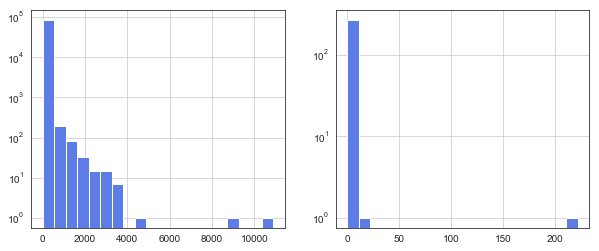

extreme bias (right)
right
right leaning
center
left leaning
left
extreme bias (left)


count       mean         std  min  25%  50%  75%  \
fake                   83113.0  13.880741  109.171063  1.0  1.0  2.0  4.0   
extreme bias (right)  114131.0  11.291279  106.990302  1.0  1.0  2.0  4.0   
right                 162860.0   7.735908   70.968451  1.0  1.0  1.0  3.0   
right leaning          98531.0   4.019588   25.712769  1.0  1.0  1.0  2.0   
center                348501.0   6.457451   79.768103  1.0  1.0  1.0  2.0   
left leaning          467853.0   5.532586   40.859005  1.0  1.0  1.0  3.0   
left                  262903.0   6.467199   50.228632  1.0  1.0  1.0  3.0   
extreme bias (left)    38972.0   4.756748   30.579443  1.0  1.0  1.0  2.0   

                          max  
fake                  10886.0  
extreme bias (right)  19300.0  
right                 15492.0  
right leaning          3096.0  
center                35043.0  
left leaning           8477.0  
left                   6015.0  
extreme bias (left)    2347.0

In [106]:
USER_TABLE = {}

for i in range(len(map_labels)):
    lab = map_labels[str(i)]
    print(lab)
    plt.figure(figsize=(10, 4))
    ax = plt.subplot(121)
    _users = all_users[all_users[lab + "_source"] > 0]
    _users[lab + "_source"].hist(ax=ax, bins=20)
    # display(all_users[lab + "_source"].describe())
    USER_TABLE[lab] = _users[lab + "_source"].describe()
    plt.yscale("log")
    
    ax = plt.subplot(122)
    IRA_users[lab + "_source"].hist(ax=ax, bins=20)
    plt.yscale("log")
    if lab == "fake":
        plt.show()
    plt.close()

    
USER_TABLE = pd.DataFrame(USER_TABLE).transpose()
USER_TABLE

In [54]:
set_IRAs_users = set()

for user_id, row in IRA_users.iterrows():
    set_IRAs_users.add(user_id)
    
# print(len(set_IRAs_users))

In [60]:
top_num = 1000

for i in range(len(map_labels)):
    lab = map_labels[str(i)]
    top_sources = set(all_users[lab + "_source"].sort_values(ascending=False).head(top_num).index)
    # print(top_sources)
    len_intersection = len(top_sources & set_IRAs_users)
    print(lab, len_intersection)

fake 1
extreme bias (right) 0
right 0
right leaning 0
center 0
left leaning 0
left 0
extreme bias (left) 0


## IRAs as influencers

fake ...
323 4272870988
510 4224729994
355 4437444442
382 3990577513
926 4355797094
853 4209684039
extreme bias (right) ...
342 4272870988
554 4311371968
903 4224729994
585 4437444442
372 3990577513
right ...
286 4272870988
285 4224729994
637 4437444442
296 3990577513
666 4209684039
right leaning ...
665 4272870988
930 4224729994
550 4355797094
758 2912754262
center ...
748 4208754922
left leaning ...
left ...
extreme bias (left) ...


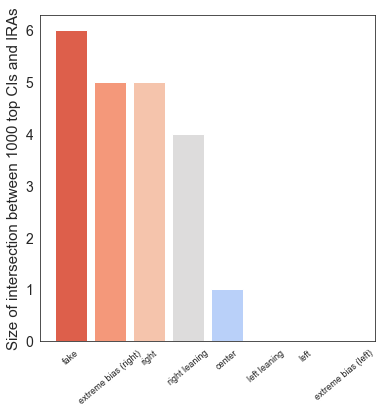

In [83]:
top_num = 1000

len_intersection = {}
f_labels = [map_labels[str(i)] for i in range(8)]
node_map = json.load(open("disk/node_map.json"))

for label in f_labels:
    print(label, "...")
    CI_rst = np.load("data/CI_rst/CI_out_{}.npy".format(label))
    CI_rank_rst = CI_rst[0][:top_num]
    # print(CI_rank_rst)
    CI_values_rst = CI_rst[1]
    
    set_CI_users = set(CI_rank_rst)
    set_source_users = set()
    
    for user_id, row in IRA_users.iterrows():
        node_id = node_map[user_id]
        set_source_users.add(node_id)
        try:
            i = CI_rank_rst.index(node_id)
            print(i, user_id)
            rank = top_num - i
        except ValueError as e:
            rank = 0

    len_intersection[label] = len(set_CI_users & set_source_users)
    
def plot_corr(cor):
    # display(cor)
    plt.figure(figsize=(6, 6))
    x = range(len(f_labels))
    for i in x:
        plt.bar(i, cor[f_labels[i]], color=sns.color_palette("coolwarm", 7)[6-i])
    plt.xticks(x, f_labels)
#     plt.xlabel('Only IRA', fontsize=15)
    plt.ylabel('Size of intersection between 1000 top CIs and IRAs', fontsize=15)
    plt.xticks(fontsize=9, rotation=40); plt.yticks(fontsize=14)
    plt.savefig("fig/size-of-intersection500.pdf", dpi=300, bbox_inches='tight')
    plt.show()
    plt.tight_layout()
    plt.close()
    
plot_corr(len_intersection)

In [24]:
IRA_users_csv = pd.read_csv("data/ira_users_csv_hashed.csv")

In [37]:
key_IRA_users = [
    "4272870988",
    "4224729994",
    "4437444442",
    "3990577513",
    "4355797094",
    "48eb1158782d382f9f9bb2c3d99f118bd88eab0bf8ef4f6f4d44494c989ad766" # "4209684039",
]

from fake_identify import Are_you_IRA

putin = Are_you_IRA()

# print(putin._map)

for k, v in putin._map.items():
    if v in key_IRA_users:
        print(k, v)

4224729994 4224729994
4355797094 4355797094
4272870988 4272870988
3990577513 3990577513
4437444442 4437444442


In [38]:
IRA_users_csv[IRA_users_csv.userid.isin(key_IRA_users)]

userid  \
11                                           3990577513   
414                                          4355797094   
1433                                         4437444442   
2642                                         4224729994   
2791  48eb1158782d382f9f9bb2c3d99f118bd88eab0bf8ef4f...   
3387                                         4272870988   

                                      user_display_name  \
11                                       Tea Party News   
414                                     Texas Lone Star   
1433                                      Pamela Kealer   
2642                                          Tennessee   
2791  48eb1158782d382f9f9bb2c3d99f118bd88eab0bf8ef4f...   
3387                                       Pamela Moore   

                                       user_screen_name  \
11                                           tpartynews   
414                                       SouthLoneStar   
1433                                     PamelaKealer13   
2642                                            TEN_GOP   
2791  48eb1158782d382f9f9bb2c3d99f118bd88eab0bf8ef4f...   
3387                                     Pamela_Moore13   

     user_reported_location  \
11                      NaN   
414              Texas, USA   
1433             Texas, USA   
2642                    NaN   
2791                    NaN   
3387             Texas, USA   

                               user_profile_description user_profile_url  \
11                                                  NaN              NaN   
414   Proud TEXAN and AMERICAN patriot #2a #prolife ...              NaN   
1433                                                NaN              NaN   
2642  Unofficial Twitter of Tennessee Republicans. C...              NaN   
2791  A silent American patriot who was awoken by Do...              NaN   
3387       Southern. Conservative. Pro God. Anti Racism              NaN   

      follower_count  following_count account_creation_date account_language  
11             21498            22407            2015-10-23               en  
414            53999            49272            2015-11-25               en  
1433           10226            10184            2015-12-10               en  
2642          147767            74664            2015-11-19               en  
2791            2688             1377            2015-11-17               en  
3387           72121            42080            2015-11-25               en

## IRAs as supporters 

In [ ]:
from collections import Counter
sns.set_style("white")
sns.color_palette("RdBu", n_colors=7)

count = Counter(first_opinion)
print(count)

label = ["pro-hillary", "pro-trump"]
plt.figure(figsize=(20, 6))

plt.subplot(131)
plt.bar(1, count[0], color=sns.color_palette("RdBu")[5], width=0.2)
plt.bar(1.5, count[1], color=sns.color_palette("RdBu")[0], width=0.2)
label = ["pro-hillary\n{0:.0%}".format(count[0] / (count[0]+count[1])), "pro-trump\n{0:.0%}".format(count[1] / (count[0]+count[1]))]
plt.xticks([1, 1.5], label)
plt.xlabel('First source', fontsize=15)
plt.ylabel('Number of tweets', fontsize=15)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)

count = Counter(staters_opinion)
print(count)

plt.subplot(132)
plt.bar(1, count[0], color=sns.color_palette("RdBu")[5], width=0.2)
plt.bar(1.5, count[1], color=sns.color_palette("RdBu")[0], width=0.2)
label = ["pro-hillary\n{0:.0%}".format(count[0] / (count[0]+count[1])), "pro-trump\n{0:.0%}".format(count[1] / (count[0]+count[1]))]
plt.xticks([1, 1.5], label)
plt.xlabel('source', fontsize=15)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)

count = Counter(other_opinion)
print(count)

plt.subplot(133)
plt.bar(1, count[0], color=sns.color_palette("RdBu")[5], width=0.2)
plt.bar(1.5, count[1], color=sns.color_palette("RdBu")[0], width=0.2)
label = ["pro-hillary\n{0:.0%}".format(count[0] / (count[0]+count[1])), "pro-trump\n{0:.0%}".format(count[1] / (count[0]+count[1]))]
plt.xticks([1, 1.5], label)
plt.xlabel('non-source', fontsize=15)
# plt.ylabel('N of fake sources', fontsize=15)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)

plt.savefig("fig/support.pdf", dpi=300, bbox_inches='tight')
plt.show()
plt.close()